#                                   Description Triangle Algorithm                                   #
                                        
Open in VSCode or Jupyter notebook

####################### each Crownstone #######################                           

1a: Scan for surrounding nodes, store the UUID and the RSSI, and filter on RSSI if needed \
1b: Communicate with all the surrounding nodes, request RSSI and update the edges in the formed array/table \
#------------------->: Edge(node_src/node_dst/RSSI) 

2: If 2 edges are formed, Try making a triangle, by asking both edge_Dst if they can see each other \
2a Example: start at the top of the list, take a = list(i) and b = list(i+1) / two best connections, like c1/c2/-45 and c1/c3/-47 \
2b sends a message to both Crownstones, in this example c2 and c3, to ask if they can see each other in their surrounding nodes list \
2c If there is a node/vertice match, make a triangle with pointers to the edges \
#-------------------> Triangle(edgeP1/edgeP2/edgeP3) 

After forming all triangles: \
1: Go over every triangle from the triangle List and for each edge, add a triangle to a specific edge in adjacent triangle dict, with the class AdjTriangles \
2a: Each adjacent, will have otherCoord for his base dest. node, base alti x which is the altitude x coord that also lays on the axis as itself and otherCoord, \
2b: and store the altitude length that is perpendicular to the base edge, that starts/ends in the third node \
3: the map angle/Dihedral angle between two adjacent triangles, whereby the first is set as default in the XY plane, is calculated for map plotting 

####################### Communication ####################### 
                                        
Between two Crownstones:
* RequestNodeSearch: \
1: Request: a specific Crownstone checks if Node is visible in its Surrounding nodes list \
<->  \
2: Answer: specific Crownstone connection from the surrounding nodes list tuple in the format: (theAksedNode/RSSI) 

* requestTriangleSearch: \
1: Request: check if a specific edge exists in one of the edges of a triangle from the internal triangle List on the asked node \
<->  \
2: Answer: the specific Crownstone triangle containing the edge, the Triangle object has multiple pre-calculate usable values 



Mesh message between all Crownstones:  

* Global request for exchange of triangles to Hub 
* Every Cronwstone sends its best triangles (max 3-5) 


####################### Processing/Mapping ####################### 

All adjacent mapping structures will be sent to the hub. The hub will further process the triangles to a map by linking the structures with common edges.

In [98]:
# Run once to install all packages needed
# %pip install ipympl, matplotlib, networkx, numpy 

In [99]:
%matplotlib widget

import random
from random import normalvariate
import math
from math import sqrt, log10
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import networkx as nx
from IPython.display import display, clear_output
import ipywidgets as widgets
from collections import Counter
import threading
import time
import copy

In [100]:
#-----------------------------------------#

random.seed(7)

office_width = 5
office_length = 5
office_height = 3

num_nodes = 0 # if 0, take RefNodeCoords

# RefNodeCoords = [(0,0,0),(3,0,0),(0,3,0),(3,3,0),(6,0,0),(6,3,0),(1.5,1.5,2),(4.5,1.5,2)] # double pyramid
# RefNodeCoords = [(0,0,0),(0,4,0),(4,0,0),(4,4,0),(0,0,4),(0,4,4),(4,0,4),(4,4,4)] # cube
# RefNodeCoords = [(0,0,0),(4,0,0),(3.5,2,0),(1.5,3,2),(3,3,3)] # Tetraeder + extra node
# RefNodeCoords = [(0,0,0),(4,0,0),(2.0,4,0),(2,0,4),(2,2,2)] # Tetraeder + extra node, symmetric
RefNodeCoords = [(0,0,0),(4,0,0),(3.5,2,0),(1.5,3,2)] # Tetraeder
# RefNodeCoords = [(5,5,0),(1,2,0),(1,9.5,0),(7,9,0),(9.5,1.5,0),(15,15,0)] # Flat Umbrella + extra node
# RefNodeCoords = [(5,5,0),(1,2,0),(1,9.5,0),(7,9,0),(9.5,1.5,0)] # Flat Umbrella
# RefNodeCoords = [(7,3,0),(0,0,0),(4,0,0)] # Simple Triangle

DIM2D = False

if DIM2D:
    TAGCOORD = (1,1,0)
else:
    TAGCOORD = (1,1,1)

MAXTRIANGLES = 25

RSSI = False # True if using RSSI, False if using distance

#-----------------------------------------#

In [101]:
# Plot the reference node network
def compareGraph3D(Network_Dict, RefNode_List):
    G = nx.Graph()

    i = 0
    for nodeID, edges in Network_Dict.items():
        G.add_node(nodeID, pos=RefNode_List[i])
        for edge in edges:
            G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)
        i += 1

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    ax.scatter(*TAGCOORD, c="red", s=100, marker='o')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value:.3f}", color='red')

    ax.set_title("Node plot with signal strength (RSSI) (3D)")
    ax.set_ylabel("Y")
    ax.set_xlabel("X")
    ax.set_zlabel("Z")
    plt.axis('square')
    plt.show()

# Plot the mapping of the node network
def mapPlot(Edge_list, node_Dict):
    G = nx.Graph()

    for node in node_Dict.items():
        G.add_node(node[0], pos=(round(node[1][0],3),round(node[1][1],3),round(node[1][2],3)))

    for edge in Edge_list:
        G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value:.3f}", color='red')

    ax.set_title("Adjacent map of visible nodes (3D)")
    ax.set_ylabel("Y")
    ax.set_xlabel("X")
    ax.set_zlabel("Z")
    plt.axis('square')
    plt.show()

# Convert the length between two coordinates to RSSI
def distance_to_rssi(nodeCoord1, nodeCoord2):
    c1x, c1y, c1z = nodeCoord1
    c2x, c2y, c2z = nodeCoord2
    distance = sqrt((c1x-c2x)**2 + (c1y-c2y)**2 + (c1z-c2z)**2)
    # noise = normalvariate(0, sqrt(20))
    noise = 0
    rssi = -70 - 10 * 2.0 * log10(distance) + noise
    if RSSI:
        return rssi
    else:
        return distance


# Convert RSSI into distance, for now a log function or later try neural net conversion
def rssi_to_distance(rssi):
    if RSSI:
        return (10**((-rssi-70)/(20)))
    else:
        return rssi

# Planar Roll rotation will turn plane YZ around X
def roll(phi):
    phi = np.deg2rad(phi)
    return np.array([[1, 0, 0],
                     [0, np.cos(phi),  -np.sin(phi)],
                     [0, np.sin(phi), np.cos(phi)]])

# Planar PITCH rotation will turn plane XZ around Y
def pitch(theta):
    theta = np.deg2rad(theta)
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

# Planar YAW rotation will turn plane XY around Z
def yaw(psi):
    psi = np.deg2rad(psi)
    return np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])

# Mirror X coord by placing mirror in YZ plane
def mirrorX():
    return np.array([[-1, 0, 0],
                     [ 0, 1, 0],
                     [ 0, 0, 1]])

# Mirror Y coord by placing mirror in XZ plane
def mirrorY():
    return np.array([[1, 0, 0],
                     [0,-1, 0],
                     [0, 0, 1]])

# Mirror Z coord by placing mirror in XY plane
def mirrorZ():
    return np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0,-1]])

In [102]:
# Node class, which represents a individual Crownstone
class Node:

    def __init__(self, HWuuid: str):
        self.uuid = HWuuid
        self.coord = (0,0,0)
        self.SurNodes = [] # list of (node reference, rssi)
        self.adjEdgeList = []
        self.oppEdgeList = []
        self.triangleList = []
        self.adjTrianglesDict = {}
        
        self.mapCoordsDict = {}
        self.mapEdgeSetDict = {}
        self.mappingDict = {}
        self.transCoordsDict = {}

        self.tagDistance = 0
   
    def __repr__(self):
        return str(self)
    
    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.adjEdgeList))
        triangles_str = '\n'.join(map(str, self.triangleList))
        nodes_str = ', '.join(map(str, [node.uuid for node, rssi in self.SurNodes])) 
        oppos_str = ', '.join(map(str, self.oppEdgeList)) 
        line = "------------------------------------------------------------------------------------------------\n"
        return f"{line}Node uuid={self.uuid}:{self.coord} [:] Surrounding Nodes= {nodes_str}, Edgelist= {edges_str}\n\nTriangleList:\n{triangles_str}\n\nOpposite edges={oppos_str} [:]\n"
    
    # Print all node information
    def printNodeInfo(self):
        print(self)
        if len(self.adjTrianglesDict) == 0:
            print("No adj triangles dict")
            return
        
        print(f"Adjacent triangles of {self.uuid}:") 
        for edge, adj_list in self.adjTrianglesDict.items():
            print(f"Edge {edge.id}:")
            for adj in adj_list:
                print(adj)

        print('\nPlotting the coordinate map of each base edge:')
        for edge, mapCoords in self.mapCoordsDict.items():
            print(f'Base_edge {edge}:')
            for coord in sorted(mapCoords.items()):
                print(f"Node {coord[0]}: ({coord[1][0]:.3f},{coord[1][1]:.3f},{coord[1][2]:.3f})")
            print()

        print('\nFor each map, the translations:')
        for edge, mapping in self.mappingDict.items():
            print(f'Base Edge {edge}:')
            for uuid, rotations in mapping.items():
                rot_str = [', '.join(map(str, row)) for row in rotations]
                print(f"Node {uuid}: Rotations= {rot_str}")
            print()

        print('\nAfter translation:')
        for edge, mapCoords in self.transCoordsDict.items():
            print(f'Base_edge {edge}:')
            for node, coord in sorted(mapCoords.items()):
                print(f"Node {node}: ({coord[0]:.3f},{coord[1]:.3f},{coord[2]:.3f})")
            print()
        print()
        print("------------------------------------------------------------------------------------------------\n")
      
    def compare(self, other: object):
        return self.uuid == other.uuid
    
    # Initial scan for surrounding nodes in the environment 
    def scanSurroundings(self, network_edges, tag_distances):
        surNodeSet = set()
        self.tagDistance = tag_distances[self.uuid]
        for edge in network_edges[self.uuid]:
            surNodeSet.add((edge.dst,edge.rssi))
        self.SurNodes = sorted(surNodeSet, key=lambda x: x[1], reverse=RSSI)

    # Node search request for searched_Node at target_node
    def requestNodeSearch(self, target_node, searched_Node):
        # send BLE message to target and wait for response
        found = target_node.nodeSearch(searched_Node)
        if (found == False):
            print(f"{self.uuid}: Node NOT visible")
        else:
            return found # (Node, RSSI)

    # NodeSearch response, checks if requested node is visible in surroundings
    def nodeSearch(self, checkFor: object) -> tuple:
        for surNode in self.SurNodes:
            if surNode[0] == checkFor:
                return surNode
        return False
    
    # Checks if edge is in current list of edges
    def checkEdge(self, check_edgeDst):
        for edge in self.adjEdgeList:
            if edge.dst == check_edgeDst:
                return edge
        return False
    
    # Make a new edge from the supplied nodes and add it to the adjEdgeList if it does not exist already
    def addEdge(self, node1, node2, rssi):
        # check if Edge not already exist
        if self.checkEdge(node2) == False:
            newEdge = Edge(node1, node2, rssi)
            self.adjEdgeList.append(newEdge)
            return True
        else:
            # print("Duplicate!")
            return False

    # Creates an edge with other_sur by making a requestNodeSearch() for itself at other_sur.
    # The edge will be stored in the adjacent edge list, it uses the rssi of other_sur. 
    # List will be sorted due to sorted sur_nodes
    def createEdgeWith(self, other_Sur: tuple):
        check = self.requestNodeSearch(other_Sur[0],self)
        if check == False:
            print(f"{self.uuid}: Can not form edge, Node not visible!")
            return False
        else:
            return self.addEdge(self,other_Sur[0],other_Sur[1])
    
    # Check if triangle is already added to internal trianglelist
    def checkTriangle(self, checkTriangle):
        for triangle in self.triangleList:
            if triangle == checkTriangle:
                return True
        return False
    
    # Internal triangle/opposite_edge search in all triangles of the trianglelist
    def triangleSearch(self, opposite_edge):
        start_time = time.time()
        for triangle in self.triangleList:
            if triangle.hasEdge(opposite_edge):
                return triangle
        print(f'No triangle: {self.uuid}:{opposite_edge.src.uuid}:{opposite_edge.dst.uuid}')
        return False  
    
    # Internal triangle/opposite_edge search in all triangles of the trianglelist
    def adjDictSearch(self, baseEdge, thirdNodeUUID):
        for adj in self.adjTrianglesDict[baseEdge]:
            if thirdNodeUUID in adj.triangle.unique:
                return adj
        return None
                   
    # Triangle search request for target, should actually return the needed values instead of whole Triangle object
    def requestTriangleSearch(self, target_Node, searched_Edge):
        # send BLE message to target and wait for response
        return target_Node.triangleSearch(searched_Edge)

    # Adjacent Triangle search request for target, should actually return the needed values instead of whole Triangle object
    def requestAdjTriangleSearch(self, target_Node, searched_Edge):
        # send BLE message to target and wait for response
        return target_Node.adjMapSearch(searched_Edge)

    # Make a new triangle from the supplied edges and add it to the trianglist if it does not exist already, 
    def addTriangle(self, edge1,edge2,common_edge):
        temp = Triangle(edge1,edge2,common_edge)
        # check if triangle not already exist, false is not in list
        if self.checkTriangle(temp) == False: # and temp.area > 0.5:
            self.oppEdgeList.append(common_edge)
            self.oppEdgeList.sort(key=lambda x: x.rssi,reverse=RSSI)
            self.triangleList.append(temp)
            self.triangleList.sort(key=lambda x: x.contribution, reverse=True)
            # self.triangleList.sort(key=lambda x: x.area, reverse=False)
            return True
        else:
            # print("Duplicate!")
            return False

    # create temporary triangle to make altitude and angle calculations    
    def createTempTriangle(self, defaultOtherNode, otherNode):
        checkForOther = self.requestNodeSearch(defaultOtherNode,otherNode)
        checkForDef = self.requestNodeSearch(otherNode,defaultOtherNode)
        if checkForOther == False or checkForDef == False:
            print(f"{self.uuid}: Check Error {defaultOtherNode.uuid} {otherNode.uuid}")
            return False
        if checkForOther[0].compare(otherNode) and checkForDef[0].compare(defaultOtherNode):
            common_edge = Edge(defaultOtherNode,otherNode,checkForDef[1])       
            temp = Triangle(Edge(self,defaultOtherNode,self.nodeSearch(defaultOtherNode)[1]),Edge(self,otherNode,self.nodeSearch(otherNode)[1]),common_edge)
            # print(f'{self.uuid}: Temp triangle = {temp}')
            return temp
        else:
            print(f"{self.uuid}: Compare Error {defaultOtherNode.uuid} {otherNode.uuid}")
            return False
        
    # Triangle search request for target
    def requestTempTriangle(self, target_Node, defaultNode, otherNode):
        # send BLE message to target and wait for response
        return target_Node.createTempTriangle(defaultNode,otherNode)

    # Creates a Triangle with self, dst1 and dst2, by making a requestNodeSearch() at dst1 for dst2, and at dst2 for dst1.
    # If there is mutual agreement, an edge between dst1 and dst2 will be made and stored in opposite edge list. 
    # The three edges will be added togheter to form a new triangle
    def createTriangleWith(self, edge1, edge2):
        dst1, dst2 = edge1.dst, edge2.dst
        if self.compare(dst1) or self.compare(dst2):
            print(f"{self.uuid}: Can not make Triangle with itself")
            return False
        
        checkForDst2 = self.requestNodeSearch(dst1,dst2)
        checkForDst1 = self.requestNodeSearch(dst2,dst1)
        if checkForDst2 == False or checkForDst1 == False:
            print(f"{self.uuid}: Triangle not possible, no common edge")
            return False
        if checkForDst2[0].compare(dst2) and checkForDst1[0].compare(dst1):
            common_edge = Edge(dst1,dst2,checkForDst1[1])
            return self.addTriangle(edge1,edge2,common_edge)


    # This procedure will walk all the nodes and will make N triangles. routine: iterate surnodes, make edge from first, add them to edgelist, 
    # check if edge sees other edge, if True, form edges and make triangle, add triangle to trianglelist
    def triangleProcedure(self):
        surCount = len(self.SurNodes)
        for i in range(surCount):
            for j in range(i+1, surCount):
                self.createEdgeWith(self.SurNodes[i]) # tuple(node,rssi)
                self.createEdgeWith(self.SurNodes[j])
                edgeP1 = self.checkEdge(self.SurNodes[i][0]) # search on dst node
                edgeP2 = self.checkEdge(self.SurNodes[j][0]) 
                self.createTriangleWith(edgeP1,edgeP2)
                if len(self.triangleList) == MAXTRIANGLES:
                    # TODO: replace when lower weight, max_triangles
                    return
    
    # Links all triangles from trianglelist to individual edges from the edgelist, so edge(AB) has adj
    def createAdjTriangles(self):
        if len(self.adjEdgeList) == 0 or len(self.triangleList) == 0:
            print(f"{self.uuid}: NO edges or triangles")
            return False 
        
        triangle_dict = {}
        for base_edge in self.adjEdgeList:
            for triangle in self.triangleList:
                if triangle.hasEdge(base_edge):
                    adjTriangle = Adjacent(triangle)
                    if base_edge not in triangle_dict:
                        adjTriangle.setCoord((base_edge.dst.uuid,base_edge.dist))
                        triangle_dict[base_edge] = [adjTriangle]
                    else:
                        triangle_dict[base_edge].append(adjTriangle)          
        self.adjTrianglesDict = triangle_dict
    

    # ABC and ABD: From the two adjacent nodes C and D, get the height and xpos of the altitude, calculate dXpos
    # Get the distance between C and D, together with dXpos calculate the translation with pythagoras.
    # Dihedral angle calculation with Triangle()
    def getMapAngle(self, defaultOtherNode, otherNode,base_altiX,altiX,base_altiH,altiH):
        reqTri = self.triangleSearch(Edge(defaultOtherNode,otherNode,0)) # first check internal
        if reqTri == False:
            # call make temp triangle, for calculation of altitude -> angle
            reqTri = self.createTempTriangle(defaultOtherNode,otherNode)
            if reqTri == False:
                return None
   
        nodeDist = reqTri.edges[2].dist
        deltaX = abs(base_altiX - altiX)
        pyth = max(0, nodeDist**2 - deltaX**2)

        translation = sqrt(pyth)
        a, b, c = translation, base_altiH, altiH
        if c == 0:
            return 0
        else:
            p = max(-1, min(1, (b**2 + c**2 - a**2) / (2 * b * c)))
            mapAngle = np.rad2deg(np.arccos(p)) 
            return mapAngle
    

    # Requests altitude position and height from the askNode
    # for example: you are A in triangle ABC, base_edge AB, askNode C, check if it has triangle with the values for altitude information 
    def mapAltiRequest(self, askNode, base_edge, self_angle):
        reqTri = self.requestTriangleSearch(askNode, base_edge)
        if reqTri == False:
            # call make temp triangle at target_node, for calculation of altitude -> angle
            reqTri = self.requestTempTriangle(askNode,base_edge.src,base_edge.dst)
            if reqTri == False:
                return None, None

        if reqTri.altiX[0][0] == self.uuid: # return the x pos from perspective self, to the asked node
            if self_angle > 90:
                return (reqTri.altiX[0][0],-reqTri.altiX[0][1]), reqTri.altiH # list(tuple(node,-alti),tuple(node,alti))
            else:
                return reqTri.altiX[0], reqTri.altiH # list(tuple(node,alti),tuple(node,alti))
        else:
            if self_angle > 90:
                return (reqTri.altiX[1][0],-reqTri.altiX[1][1]), reqTri.altiH # list(tuple(node,-alti),tuple(node,alti))
            else:
                return reqTri.altiX[1], reqTri.altiH # list(tuple(node,alti),tuple(node,alti))
    
    def adjMapHelper(self, baseEdge, baseNode, thirdNode):
        adj = self.adjDictSearch(baseEdge, thirdNode.uuid)
        if adj != None:
            coord = np.array([adj.basealtiX[1], adj.basealtiH[1], 0.000])  
            adj_base = self.adjDictSearch(baseEdge, baseNode.uuid)
            angle = self.getMapAngle(baseNode,thirdNode,adj_base.basealtiX[1],adj.basealtiX[1],adj_base.basealtiH[1],adj.basealtiH[1])
            mapped = np.dot(roll(angle), coord)
            return (mapped[0],mapped[1],mapped[2]), angle

    # Iterates on the adjacent triangles, set the first on XY/default and calculate for the following triangles the angle between default, altiX, altiH 
    def mapAdjacents(self):
        for base_edge, adj_list in self.adjTrianglesDict.items():
            defaultOtherNode = adj_list[0].triangle.getLastNode(base_edge)
            selfAngle = adj_list[0].triangle.angle[1]  # tuple(node,angle)
            base_altiX, base_altiH = self.mapAltiRequest(defaultOtherNode,base_edge, selfAngle)

            if base_altiX == None or base_altiH == None:
                print(f"{self.uuid}: mapAltiRequest failed!")
            else:
                adj_list[0].setAltiH(base_altiH)
                adj_list[0].setAltiX(base_altiX)        
            for i in range(1,len(adj_list)):
                otherNode = adj_list[i].triangle.getLastNode(base_edge)
                selfAngle = adj_list[i].triangle.angle[1] # tuple(node,angle)
                altiX, altiH = self.mapAltiRequest(otherNode,base_edge,selfAngle)
            
                if altiX == None or altiH == None:
                    print(f"{self.uuid}: mapAltiRequest failed!")
                else:
                    adj_list[i].setAltiH(altiH)
                    adj_list[i].setAltiX(altiX)
                    adj_list[i].setCoord(('X',0))

                    angle = self.getMapAngle(defaultOtherNode,otherNode,base_altiX[1],altiX[1],base_altiH[1],altiH[1])
                    if angle == None:
                        print(f"{self.uuid}: mapAngle failed!")
                    else:
                        adj_list[i].setAngle(angle)
                        newCoord = np.dot(roll(angle),np.array([altiX[1], altiH[1], 0.00]))
                        adj_list[i].setMapHeight((newCoord[0],newCoord[1],newCoord[2]))
  
    # MakeMap of coords with a check from the other edge of the base triangle and a tetraeder node distance check
    def makeMap(self):

        def calc_distance(coord1, coord2):
            return sqrt((coord1[0]-coord2[0])**2 + (coord1[1]-coord2[1])**2 + (coord1[2]-coord2[2])**2)

        for base_edge, adjList in self.adjTrianglesDict.items():

            mapEdgeSet = []

            mapping = {base_edge.src.uuid:np.identity(3), base_edge.dst.uuid:np.identity(3),}
            
            baseTriangle = adjList[0].triangle

            mapCoords = {self.uuid: self.coord, 
                base_edge.dst.uuid:(adjList[0].otherCoord[1],0.000,0.000), 
                baseTriangle.getLastNode(base_edge).uuid:(adjList[0].basealtiX[1],adjList[0].basealtiH[1],0.000), }
            
            lastNode = self

            # go over all triangles and place the coords on the x-axis and rotate, also make list of all edges from all adj triangles
            for i, adj in enumerate(adjList):
                rotation_matrix = np.identity(3)
                rotation_matrix = np.dot(yaw(adj.triangle.angle[1]), rotation_matrix)
                mapEdgeSet.extend(edge for edge in adj.triangle.edges if not any(edge.compare(existing_edge) for existing_edge in mapEdgeSet))
                thirdNode = adj.triangle.getLastNode(base_edge)
                if i == 0:
                    mapping.update({thirdNode.uuid:rotation_matrix})
                    continue

                otherBaseEdge = baseTriangle.getOtherBaseEdge(base_edge)
                mapped, angle = self.adjMapHelper(otherBaseEdge, base_edge.dst, thirdNode)
                rotation_matrix = np.dot(roll(angle), rotation_matrix)
                # yaw + roll
                if round(mapped[0],3) == round(adj.mappedHeight[0],3) and round(mapped[1],3) == round(adj.mappedHeight[1],3) and round(mapped[2],3) == round(adj.mappedHeight[2],3):
                    mapCoords.update({thirdNode.uuid:(mapped[0],mapped[1],mapped[2])})
                else:
                    remapped = np.dot(yaw(baseTriangle.angle[1]), mapped)
                    triangle = self.triangleSearch(Edge(lastNode,adj.triangle.getLastNode(base_edge),0))
                    edge_dist = triangle.getEdge(Edge(lastNode,adj.triangle.getLastNode(base_edge),0)).dist
                    # yaw + roll
                    if round(remapped[0],3) == round(adj.mappedHeight[0],3) and round(remapped[1],3) == round(adj.mappedHeight[1],3) and round(remapped[2],3) == round(adj.mappedHeight[2],3):
                        distance = calc_distance(mapCoords[lastNode.uuid],remapped)
                        rotation_matrix = np.dot(yaw(baseTriangle.angle[1]), rotation_matrix)
                        # yaw + roll + yaw
                        if round(edge_dist,3) == round(distance,3):
                            mapCoords.update({thirdNode.uuid:(remapped[0],remapped[1],remapped[2])})
                        else:
                            # yaw + roll + yaw + mirrorZ
                            rotation_matrix = np.dot(mirrorZ(), rotation_matrix)
                            remapped = np.dot(mirrorZ(), remapped)
                            distance = calc_distance(mapCoords[lastNode.uuid],remapped)
                            if round(edge_dist,3) == round(distance,3):
                                mapCoords.update({thirdNode.uuid:(remapped[0],remapped[1],remapped[2])})
                            else:
                                mapCoords.update({thirdNode.uuid:(0,0,0)})
                    else:
                        # yaw + roll
                        remapped = np.dot(yaw(-baseTriangle.angle[1]), remapped)
                        remapped = np.dot(mirrorY(), remapped)
                        remapped = np.dot(yaw(baseTriangle.angle[1]), remapped)
                        if round(remapped[0],3) == round(adj.mappedHeight[0],3) and round(remapped[1],3) == round(adj.mappedHeight[1],3) and round(remapped[2],3) == round(adj.mappedHeight[2],3):
                            distance = calc_distance(mapCoords[lastNode.uuid],remapped)
                            rotation_matrix = np.dot(mirrorY(), rotation_matrix)
                            rotation_matrix = np.dot(yaw(baseTriangle.angle[1]), rotation_matrix)
                            # yaw + roll + mirrorY + yaw
                            if round(edge_dist,3) == round(distance,3):
                                mapCoords.update({thirdNode.uuid:(remapped[0],remapped[1],remapped[2])})
                            else:
                                # yaw + roll + mirrorY + yaw + mirrorZ
                                rotation_matrix = np.dot(mirrorZ(), rotation_matrix)
                                remapped = np.dot(mirrorZ(), remapped)
                                distance = calc_distance(mapCoords[lastNode.uuid],remapped)
                                if round(edge_dist,3) == round(distance,3):
                                    mapCoords.update({thirdNode.uuid:(remapped[0],remapped[1],remapped[2])})
                                else:
                                    mapCoords.update({thirdNode.uuid:(0,0,0)})
                        else:
                            mapCoords.update({thirdNode.uuid:(0,0,0)})
                            
                mapping.update({thirdNode.uuid:rotation_matrix})
                lastNode = thirdNode
            
            self.mapCoordsDict.update({base_edge.id: mapCoords})
            self.mapEdgeSetDict.update({base_edge.id: mapEdgeSet})
            self.mappingDict.update({base_edge.id: mapping})
    
    # function should use the first translation map, multiply the first coord map with the base_edge.dst
    # coordinates multiple with translation (factor, angle, map angle)
    def rotateCoords(self):
        # base_coords = self.mapCoordsDict[self.adjEdgeList[0].id]
        self.transCoordsDict = copy.deepcopy(self.mapCoordsDict)

        for base_edge, mapCoord in self.transCoordsDict.items():
            # rotMatrix = base_coords[base_edge[1]]
            rotMatrix = self.mappingDict[base_edge][self.adjEdgeList[0].dst.uuid]
            for uuid, coord in mapCoord.items():
                remapped = np.array([coord[0], coord[1],coord[2]]) 
                remapped = np.dot(np.linalg.inv(rotMatrix), remapped)

                mapCoord.update({uuid:(remapped[0],remapped[1],remapped[2])})

                # if round(remapped[0],3) == round(base_coords[uuid][0],3) and round(remapped[1],3) == round(base_coords[uuid][1],3) and round(remapped[2],3) == round(base_coords[uuid][2],3):
                #     mapCoord.update({uuid:(remapped[0],remapped[1],remapped[2])})
                # else:
                #     mapCoord.update({uuid:(0,0,0)})

    def getTagDistance(self):
        return self.tagDistance

    def requestTagDistance(self, target_Node):
        # send BLE message to target and wait for response
        return target_Node.getTagDistance()

    def triangleLocalisation(self):
        tagRSSI = self.getTagDistance()

        # request tag distance of other nodes in triangle
        for adj in self.adjTrianglesDict[self.adjEdgeList[0]]:
            nodeRSSI1 = self.requestTagDistance(adj.triangle.nodes[1])
            nodeRSSI2 = self.requestTagDistance(adj.triangle.nodes[2])
            otherRSSI1 = self.nodeSearch(adj.triangle.nodes[1])[1]
            otherRSSI2 = self.nodeSearch(adj.triangle.nodes[2])[1]  
            print(f"({self.uuid})={tagRSSI}::{otherRSSI1}::{otherRSSI2}::{nodeRSSI1}::{nodeRSSI2}")
            
            # calculate the x,y,z position of the tag with a neural network: self.neuralNetwork(tagRSSI, otherRSSI1, otherRSSI2, nodeRSSI1, nodeRSSI2)
            # OR
            # calculate the x,y,z position of the tag with a trilateration algorithm


    # init function, scan surroundings, make triangles
    def init(self, network_edges, tag_distances):
        self.scanSurroundings(network_edges, tag_distances)
        time.sleep(5)
        self.triangleProcedure()
        time.sleep(5)

    # main function, calls init first, for getting edges amd triangles, after: create adj triangles, map adjacents, make map, rotate coords, print node info
    def main(self, network_edges, tag_distances):
        self.init(network_edges, tag_distances)
        self.createAdjTriangles()
        self.mapAdjacents()
        time.sleep(5)
        self.makeMap()
        time.sleep(7)
        self.rotateCoords()
        time.sleep(7)
        self.triangleLocalisation()
        # self.printNodeInfo()
       

class Edge:

    def __init__(self, src: Node, dst: Node, rssi):
        self.id = (src.uuid,dst.uuid)
        self.src = src
        self.dst = dst
        self.rssi = rssi
        self.dist = rssi_to_distance(rssi)

    def __str__(self) -> str:
        return f"({self.src.uuid},{self.dst.uuid},{self.dist:.3f})"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(self.id)
    
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    def compare(self, other: object):
        return (self.src.uuid, self.dst.uuid) == (other.src.uuid, other.dst.uuid) or (self.src.uuid, self.dst.uuid) == (other.dst.uuid, other.src.uuid)
    
# triangles are stored locally and node specific, iow: edge are in the orientation of the node, ab, ac, bc
class Triangle:

    def __init__(self, edge1: Edge, edge2: Edge, edge3: Edge):
        self.edges = [edge1,edge2,edge3]
        self.area = self.getArea()
        self.nodes = [edge1.src, edge3.src, edge3.dst] # startnode|opposite edge src node|opposite edge dst node
        self.unique = sorted(set(node.uuid for node in self.nodes))
        self.ID = "|".join(map(str, self.unique))
        self.contribution = self.area / max(edge1.dist, edge2.dist, edge3.dist) # higher is better

        self.angle = self.getAngle()
        self.altiH = self.getAltitudeH()
        self.altiX = self.getAltitudeX() # from both adjacent edge perspectives, list of two

    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.edges))
        return f"Triangle {self.ID}: Area= {self.area:.3f}, Contribution= {self.contribution:.3f}, Edges= {edges_str}, Angles=({self.angle[0]},{self.angle[1]:.3f}), Altitude=(x=[(To {self.altiX[0][0]},{self.altiX[0][1]:.3f}),(To {self.altiX[1][0]},{self.altiX[1][1]:.3f})], H=[{self.altiH[0]},{self.altiH[1]:.3f}])"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(f'{self.unique}')
      
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    # Checks if triangle has the edge_to_check in its edges
    def hasEdge(self, edge_to_check: Edge):
        for i, edge in enumerate(self.edges):
            if edge.compare(edge_to_check):
                return True
        return False
    
    # Returns the edge_to_check if it is in the triangle
    def getEdge(self, edge_to_check: Edge):
        for edge in self.edges:
            if edge.compare(edge_to_check):
                return edge
        return None

    # Returns the last node spanning the triangle, based on the base_edge src and dst node
    def getLastNode(self, base_edge: Edge):
        for node in self.nodes:
            if node != base_edge.src and node != base_edge.dst:
                return node

    def getOtherBaseEdge(self, base_edge: Edge):
        if self.edges[0].compare(base_edge):
            return self.edges[1]
        else:
            return self.edges[0]               

    # Calculates the angle of the triangle from the node perspective corner     
    def getAngle(self): # ab0 ac1 bc2              
        a = self.edges[2].dist # edge bc  
        b = self.edges[1].dist # edge ac  
        c = self.edges[0].dist # edge ab
        p = (b**2+c**2-a**2)/(2*b*c)
        q = max(-1, min(1, p))
        angle = np.rad2deg(np.arccos(q))
        return (self.edges[0].src.uuid, angle)
    
    # calculate the area of the triangle with Heron's formula
    def getArea(self):
        a = self.edges[2].dist # edge bc  
        b = self.edges[1].dist # edge ac  
        c = self.edges[0].dist # edge ab
        # Heron's formula 
        s = (a + b + c) / 2
        div = s * (s - a) * (s - b) * (s - c)
        # check if nodes are inline -> angle 0 or 180
        if div < 0: 
            div = 0
        return sqrt(div) 

    # Calculates the altitude height of the triangle from node perspective with Heron's formula, see getArea() 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude height is from corner A to side bc       
    def getAltitudeH(self):
        a = self.edges[2].dist # opposite edge bc         
        height = (2 * self.area) / a
        return (self.edges[0].src.uuid, height)
    
    # Calculates the altitude X position with pythogoras from the node perspective corner onto the opposite edge. 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude x position is from perspective of A, and lays on the opposite edge (0,0,0)->(x,0,0)   
    def getAltitudeX(self):  # ab0 ac1 bc2
        ab_squared = self.edges[0].dist ** 2
        ac_squared = self.edges[1].dist ** 2
        hA_squared = self.altiH[1] ** 2

        # Pythagoras formula
        divB = ab_squared - hA_squared
        divC = ac_squared - hA_squared

        divB = sqrt(max(divB, 0))
        divC = sqrt(max(divC, 0))

        return [
            (self.edges[0].dst.uuid, divB),
            (self.edges[1].dst.uuid, divC)
        ]


class Adjacent:

    def __init__(self, triangle: Triangle):
        self.triangle = triangle
        self.mapAngle = 0
        self.otherCoord = (None,0)
        self.basealtiX = (None,None)
        self.basealtiH = (None,None)
        self.mappedHeight = None

    def __str__(self) -> str:
        if self.mappedHeight == None:
            return f"Triangle({self.triangle.ID}): base-coord=({self.otherCoord[0]},{self.otherCoord[1]:.3f}), map angle= {self.mapAngle:.3f} | xpos altitude=({self.basealtiX[0]},{self.basealtiX[1]:.3f}) | altitude height=({self.basealtiH[0]},{self.basealtiH[1]:.3f})-> Mapped Height = {self.mappedHeight}"
        else:
            return f"Triangle({self.triangle.ID}): base-coord=({self.otherCoord[0]},{self.otherCoord[1]:.3f}), map angle= {self.mapAngle:.3f} | xpos altitude=({self.basealtiX[0]},{self.basealtiX[1]:.3f}) | altitude height=({self.basealtiH[0]},{self.basealtiH[1]:.3f})-> Mapped Height = ({self.mappedHeight[0]:.3f},{self.mappedHeight[1]:.3f},{self.mappedHeight[2]:.3f})"
    
    def __repr__(self):
        return str(self)
    
    def setCoord(self, coord):
        self.otherCoord = coord
    
    def setAngle(self, angle):
        self.mapAngle = angle

    def setAltiX(self, xpos):
        self.basealtiX = xpos
    
    def setAltiH(self, height):
        self.basealtiH = height

    def setMapHeight(self, height):
        self.mappedHeight = height

<h1> Setup: Make n nodes and create edge list that represents the current network </h1>

List of nodes:
A, B, C, D

Reference Network Edges:
Node A:= Edges[(A,D,3.905), (A,B,4.000), (A,C,4.031)]
Node B:= Edges[(B,C,2.062), (B,A,4.000), (B,D,4.387)]
Node C:= Edges[(C,B,2.062), (C,D,3.000), (C,A,4.031)]
Node D:= Edges[(D,C,3.000), (D,A,3.905), (D,B,4.387)]

Reference Tag distances:
Node A: Distance= 1.7320508075688772
Node B: Distance= 3.3166247903554
Node C: Distance= 2.8722813232690143
Node D: Distance= 2.29128784747792


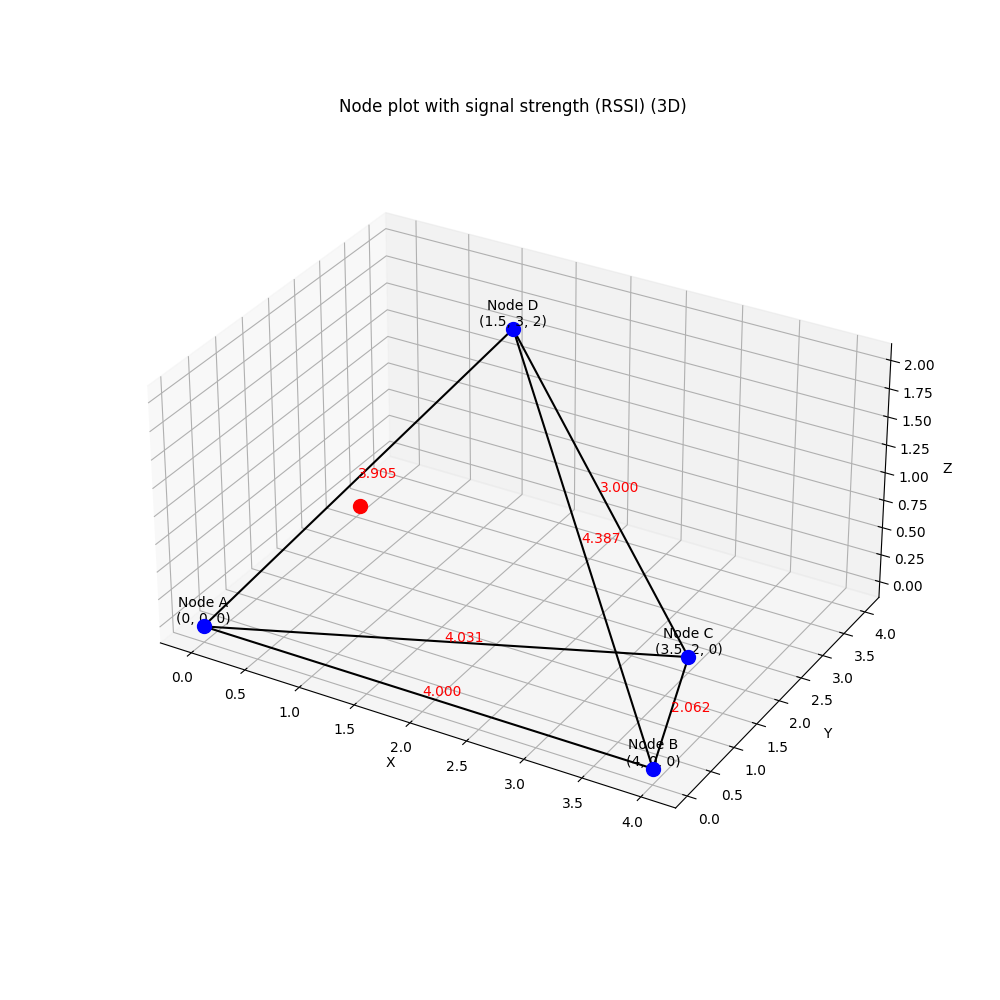

In [103]:
nodeList = []

names = [chr(x) for x in range(ord('A'), ord('Z') + 1)]

if num_nodes == 0:
    for i in range(len(RefNodeCoords)): 
        nodeList.append(Node(names[i]))
else:
    coordlist = []
    for i in range(num_nodes):
        nodeList.append(Node(names[i]))
        x = round(random.uniform(0, office_width) * 2) / 2
        y = round(random.uniform(0, office_length) * 2) / 2
        z = round(random.uniform(0, office_height) * 2) / 2
        coordlist.append((x,y,z))
       
    RefNodeCoords = coordlist

print("List of nodes:")
edge_str = ', '.join(str(node.uuid) for node in nodeList)
print(edge_str+'\n')

NetworkEdges = {}
TagDistance = {}
for i in range(len(nodeList)):
    table = []
    for j in range(len(nodeList)):
        if nodeList[i] != nodeList[j]:
            table.append(Edge(nodeList[i], nodeList[j], distance_to_rssi(RefNodeCoords[i],RefNodeCoords[j])))
    table = sorted(table, key=lambda x: x.rssi, reverse=RSSI) # if rssi set True
    TagDistance.update({nodeList[i].uuid : distance_to_rssi(RefNodeCoords[i],TAGCOORD)})
    NetworkEdges[nodeList[i].uuid] = table

print('Reference Network Edges:')
for key, edges in NetworkEdges.items():
    print(f'Node {key}:= Edges{edges}')
print()
print('Reference Tag distances:')
for key, distance in TagDistance.items():
    print(f'Node {key}: Distance= {distance}')

compareGraph3D(NetworkEdges,RefNodeCoords)

<h1> Main: getting all node data </h1>

In [104]:
# activate nodes, print function in parallel with Threading
thread_list = []
for i in range(len(nodeList)):
    thread = threading.Thread(target=nodeList[i].main, args=(NetworkEdges,TagDistance, ))
    thread_list.append(thread)
    thread.start()

for thread in thread_list:
    thread.join()

B: distance = 3.3166247903554D: distance = 2.29128784747792
C: distance = 2.8722813232690143
A: distance = 1.7320508075688772
D======2.29128784747792::3.0::3.905124837953327::2.8722813232690143::1.7320508075688772
C: distance = 2.8722813232690143
B: distance = 3.3166247903554
D======2.29128784747792::3.0::4.387482193696061::2.8722813232690143::3.3166247903554
A: distance = 1.7320508075688772
D: distance = 2.29128784747792
B: distance = 3.3166247903554
A======1.7320508075688772::3.905124837953327::4.0::2.29128784747792::3.3166247903554
D: distance = 2.29128784747792
C: distance = 2.8722813232690143
A======1.7320508075688772::3.905124837953327::4.031128874149275::2.29128784747792::2.8722813232690143
C: distance = 2.8722813232690143
B: distance = 3.3166247903554
A: distance = 1.7320508075688772
C======2.8722813232690143::2.0615528128088303::4.031128874149275::3.3166247903554::1.7320508075688772
B: distance = 3.3166247903554
D: distance = 2.29128784747792
C======2.8722813232690143::2.06155

<h1> Visualizing node data </h1>

In [105]:
nodeA = nodeList[0]
nodeA.printNodeInfo()

------------------------------------------------------------------------------------------------
Node uuid=A:(0, 0, 0) [:] Surrounding Nodes= D, B, C, Edgelist= (A,D,3.905), (A,B,4.000), (A,C,4.031)

TriangleList:
Triangle A|B|D: Area= 7.211, Contribution= 1.644, Edges= (A,D,3.905), (A,B,4.000), (D,B,4.387), Angles=(A,67.411), Altitude=(x=[(To D,2.108),(To B,2.279)], H=[A,3.287])
Triangle A|C|D: Area= 5.506, Contribution= 1.366, Edges= (A,D,3.905), (A,C,4.031), (D,C,3.000), Angles=(A,44.386), Altitude=(x=[(To D,1.333),(To C,1.667)], H=[A,3.670])
Triangle A|B|C: Area= 4.000, Contribution= 0.992, Edges= (A,B,4.000), (A,C,4.031), (B,C,2.062), Angles=(A,29.745), Altitude=(x=[(To B,0.970),(To C,1.091)], H=[A,3.881])

Opposite edges=(B,C,2.062), (D,C,3.000), (D,B,4.387) [:]

Adjacent triangles of A:
Edge ('A', 'D'):
Triangle(A|B|D): base-coord=(D,3.905), map angle= 0.000 | xpos altitude=(A,1.536) | altitude height=(B,3.693)-> Mapped Height = None
Triangle(A|C|D): base-coord=(X,0.000), map an

Base_edge ('A', 'D'):
Node A: (0.000,0.000,0.000)
Node B: (1.536,3.693,0.000)
Node C: (2.881,2.592,1.109)
Node D: (3.905,0.000,0.000)



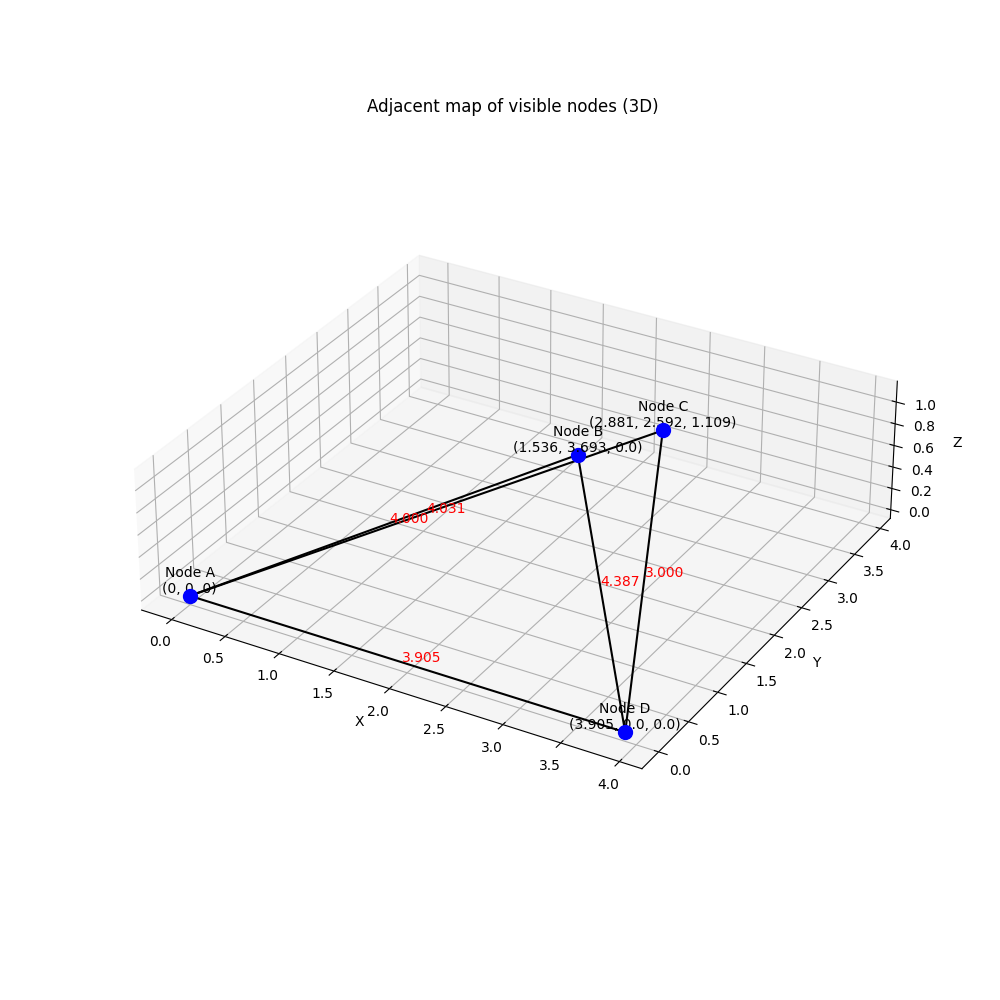

Base_edge ('A', 'B'):
Node A: (0.000,0.000,0.000)
Node B: (4.000,0.000,0.000)
Node C: (3.500,1.664,1.109)
Node D: (1.500,3.606,0.000)



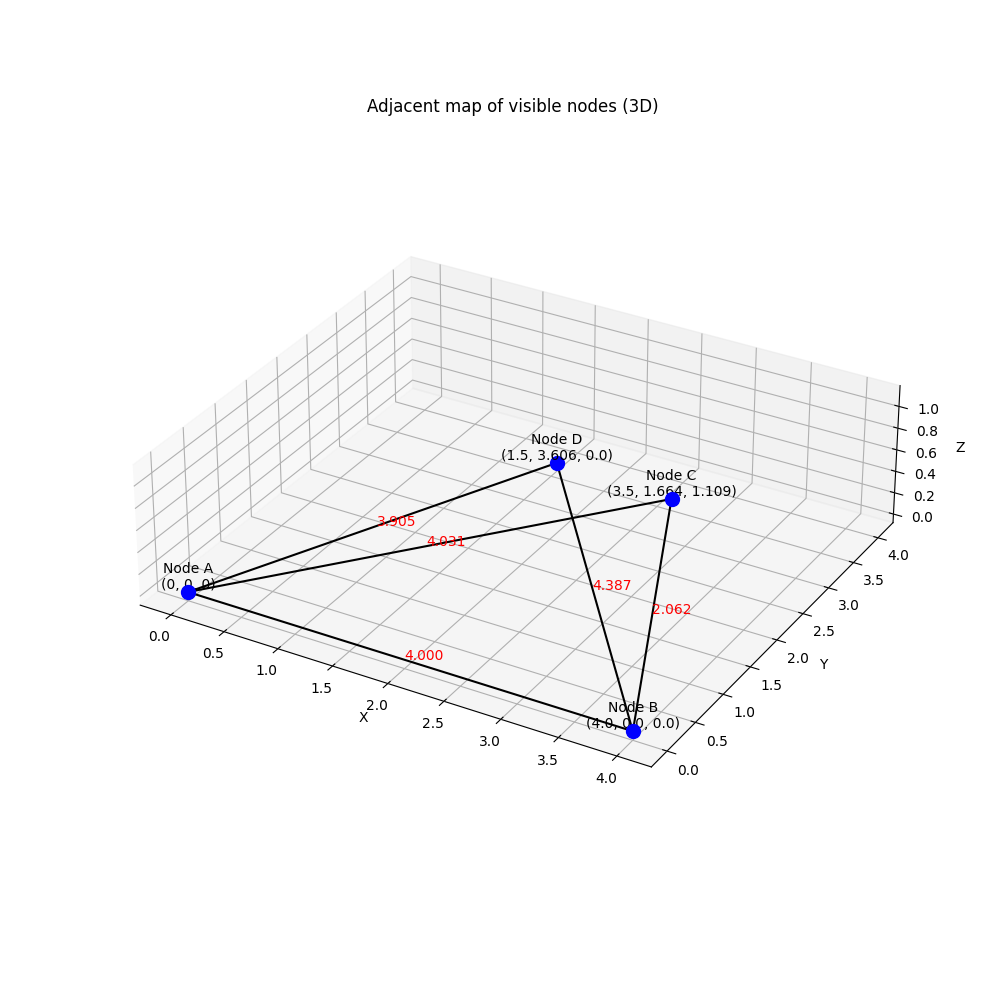

Base_edge ('A', 'C'):
Node A: (0.000,0.000,0.000)
Node B: (3.473,-1.352,1.453)
Node C: (4.031,0.000,0.000)
Node D: (2.791,2.732,0.000)



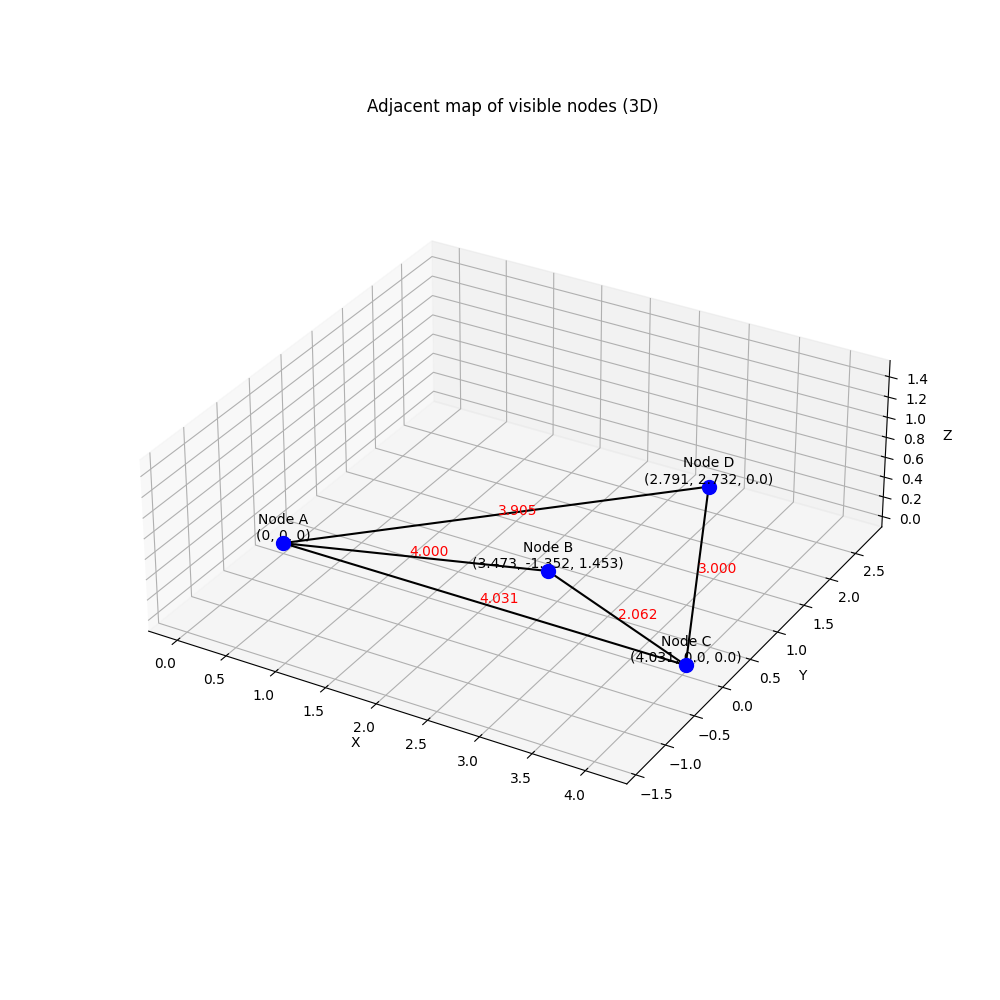

In [106]:
for (key, mapEdgeSet, mapCoords) in zip(nodeA.mapEdgeSetDict.keys(), nodeA.mapEdgeSetDict.values(), nodeA.mapCoordsDict.values()):
    print(f'Base_edge {key}:')
    for coord in sorted(mapCoords.items()):
        print(f"Node {coord[0]}: ({coord[1][0]:.3f},{coord[1][1]:.3f},{coord[1][2]:.3f})")
    print()
    mapPlot(list(mapEdgeSet), mapCoords)

In [107]:
for key, mappings in nodeA.mappingDict.items():
    print(f'Base_edge {key}:')
    for node, rotations in sorted(mappings.items()):
        rot_str = ', '.join(map(str, rotations))
        print(f"Node {node}: ({rot_str})")
    print()

Base_edge ('A', 'D'):
Node A: ([1. 0. 0.], [0. 1. 0.], [0. 0. 1.])
Node B: ([ 0.38411064 -0.92328707  0.        ], [0.92328707 0.38411064 0.        ], [0. 0. 1.])
Node C: ([ 0.81186343  0.28032604 -0.51214752], [ 0.43626793 -0.87422713  0.21306625], [0.38800524 0.39641423 0.83205029])
Node D: ([1. 0. 0.], [0. 1. 0.], [0. 0. 1.])

Base_edge ('A', 'B'):
Node A: ([1. 0. 0.], [0. 1. 0.], [0. 0. 1.])
Node B: ([1. 0. 0.], [0. 1. 0.], [0. 0. 1.])
Node C: ([ 0.7546355   0.54641239 -0.36326129], [ 0.6264353  -0.76468281  0.15112583], [0.19520264 0.34160461 0.9193488 ])
Node D: ([ 0.38411064 -0.92328707  0.        ], [0.92328707 0.38411064 0.        ], [0. 0. 1.])

Base_edge ('A', 'C'):
Node A: ([1. 0. 0.], [0. 1. 0.], [0. 0. 1.])
Node B: ([ 0.93953947  0.20377917 -0.27520837], [ 0.28135658 -0.91748588  0.28117278], [0.19520264 0.34160461 0.9193488 ])
Node C: ([1. 0. 0.], [0. 1. 0.], [0. 0. 1.])
Node D: ([ 0.71464592 -0.69948639  0.        ], [0.69948639 0.71464592 0.        ], [0. 0. 1.])



Base_edge ('A', 'D'):
Node A: (0.000,0.000,0.000)
Node B: (1.536,3.693,0.000)
Node C: (2.881,2.592,1.109)
Node D: (3.905,0.000,0.000)



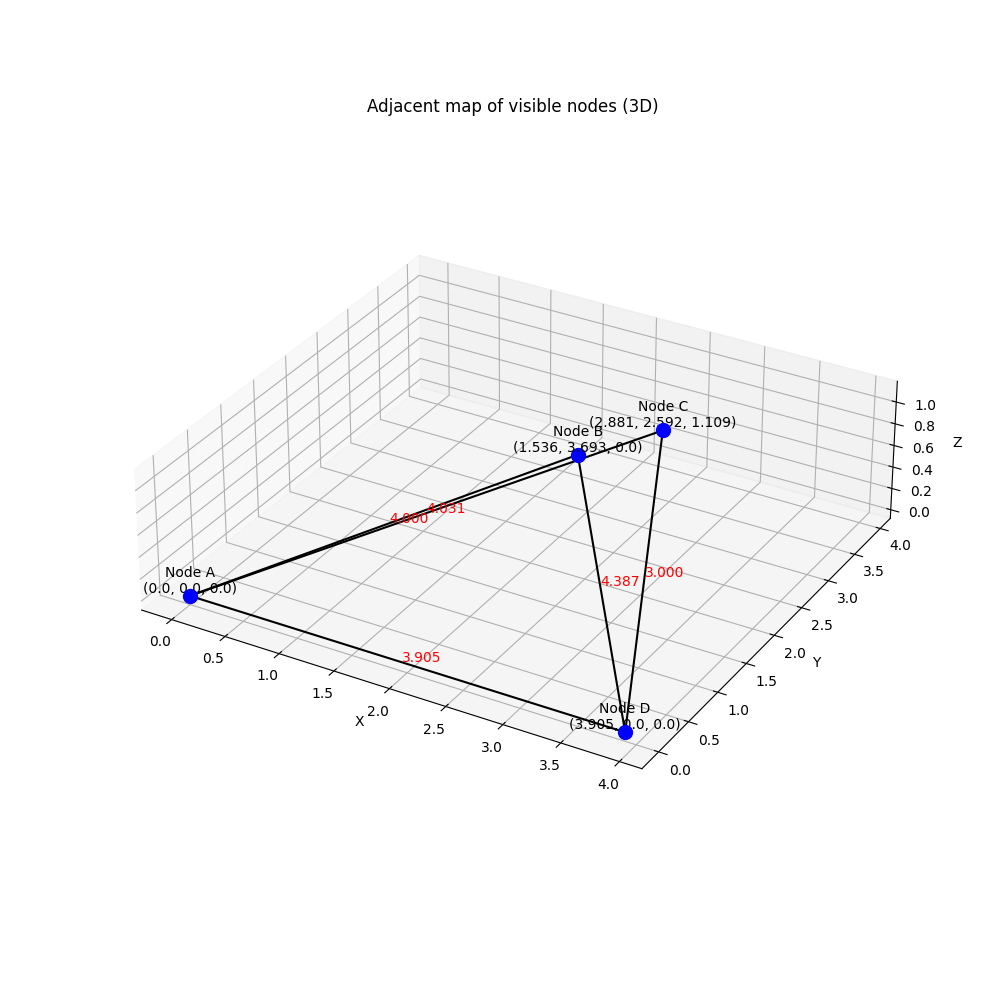

Base_edge ('A', 'B'):
Node A: (0.000,0.000,0.000)
Node B: (1.536,-3.693,0.000)
Node C: (2.881,-2.592,1.109)
Node D: (3.905,0.000,0.000)



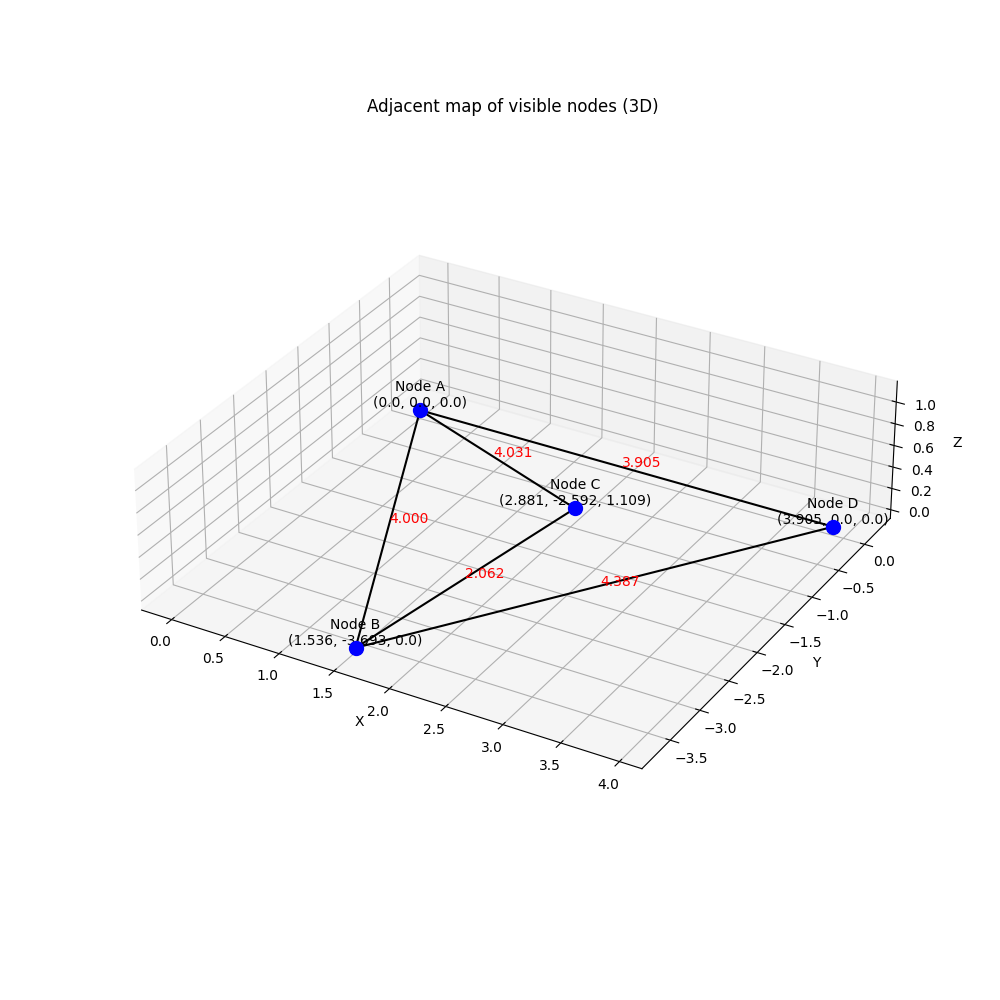

Base_edge ('A', 'C'):
Node A: (0.000,0.000,0.000)
Node B: (1.536,-3.395,1.453)
Node C: (2.881,-2.820,0.000)
Node D: (3.905,-0.000,0.000)



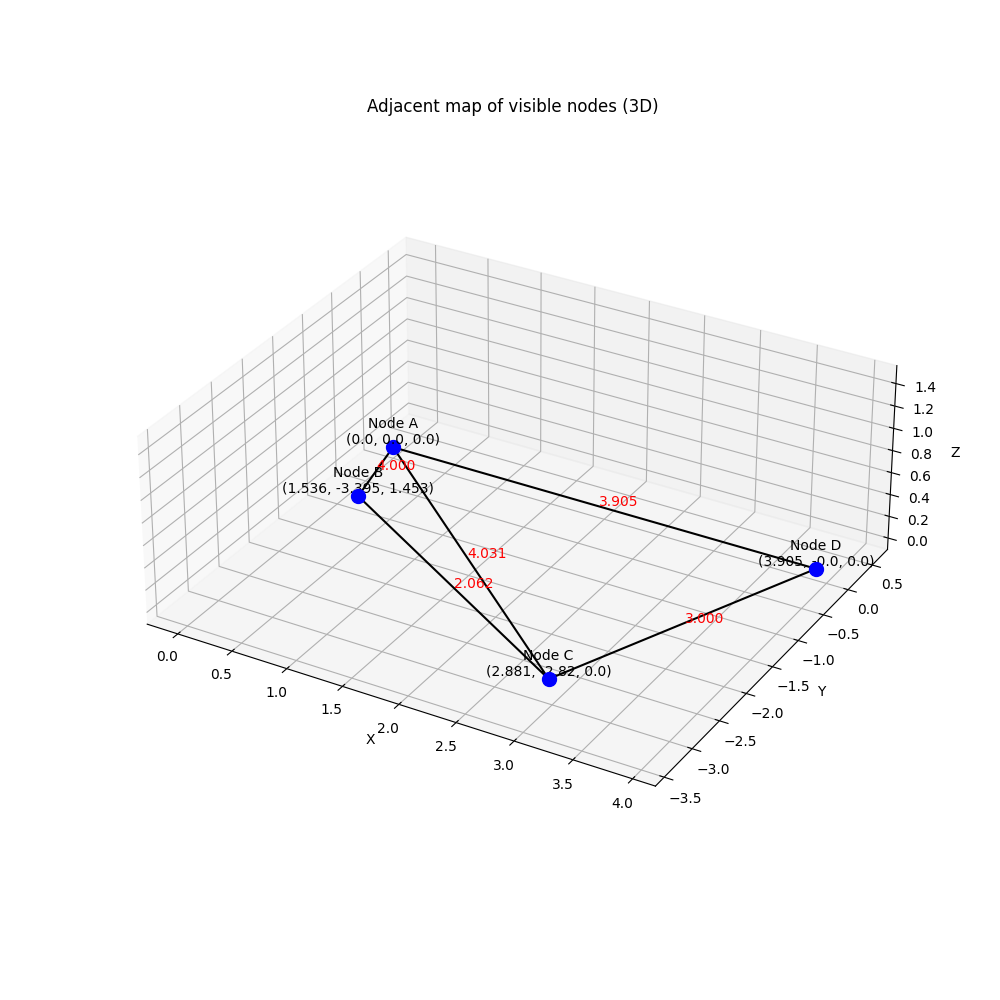

In [108]:
for (key, mapEdgeSet, mapCoords) in zip(nodeA.mapEdgeSetDict.keys(), nodeA.mapEdgeSetDict.values(), nodeA.transCoordsDict.values()):
    print(f'Base_edge {key}:')
    for coord in sorted(mapCoords.items()):
        print(f"Node {coord[0]}: ({coord[1][0]:.3f},{coord[1][1]:.3f},{coord[1][2]:.3f})")
    print()
    mapPlot(list(mapEdgeSet), mapCoords)

<H1> Development </H1>

In [109]:
# another MakeMap but now with a check from the other edge of the base triangle, tetraeder node distance check

AmapCoordDict = {}

# calc distance between two points in 3D
def calc_distance(coord1, coord2):
    return sqrt((coord1[0]-coord2[0])**2 + (coord1[1]-coord2[1])**2 + (coord1[2]-coord2[2])**2)

for base_edge, adjList in nodeA.adjTrianglesDict.items():
    print(f'Base edge: {base_edge}\n')

    for adj in adjList:
        print(adj)
    print()

    baseTriangle = adjList[0].triangle
    print(f'Base Triangle is: {baseTriangle}\n')
    baseNode = baseTriangle.getLastNode(base_edge).uuid

    AmapCoords = {nodeA.uuid: nodeA.coord, 
        base_edge.dst.uuid:(adjList[0].otherCoord[1],0.000,0.000), 
        baseNode:(adjList[0].basealtiX[1],adjList[0].basealtiH[1],0.000), }
    print(AmapCoords)
    print()
    
    lastNode = nodeA
    # go over all triangles and place the coords on the x-axis and rotate, also make list of all edges from all adj triangles
    for i, adj in enumerate(adjList):
        if i == 0:
            continue
        print()
        print(adj)

        thirdNode = adj.triangle.getLastNode(base_edge)
        otherBaseEdge = baseTriangle.getOtherBaseEdge(base_edge)
        print(f'\nCheck the  internal adjTriangleDict if the other base edge: {otherBaseEdge} has the same triangle with the node {thirdNode.uuid}')

        mapped, angle = nodeA.adjMapHelper(otherBaseEdge, base_edge.dst, thirdNode)
        if mapped != None:
            print(f'Official: ({adj.mappedHeight[0]:.3f},{adj.mappedHeight[1]:.3f},{adj.mappedHeight[2]:.3f})')
            print(f'Other  : ({mapped[0]:.3f},{mapped[1]:.3f},{mapped[2]:.3f})')
            if round(mapped[0],3) == round(adj.mappedHeight[0],3) and round(mapped[1],3) == round(adj.mappedHeight[1],3) and round(mapped[2],3) == round(adj.mappedHeight[2],3):
                AmapCoords.update({thirdNode.uuid:(mapped[0],mapped[1],mapped[2])})
            else:
                remapped = np.dot(yaw(baseTriangle.angle[1]), mapped)
                print(f'Yaw/Turn ({baseTriangle.angle[1]:.3f}) around Z ({remapped[0]:.3f},{remapped[1]:.3f},{remapped[2]:.3f})')
                if round(remapped[0],3) == round(adj.mappedHeight[0],3) and round(remapped[1],3) == round(adj.mappedHeight[1],3) and round(remapped[2],3) == round(adj.mappedHeight[2],3):
                    distance = calc_distance(AmapCoords[lastNode.uuid],remapped)
                    print(f'Distance between {lastNode.uuid}-{thirdNode.uuid}: {distance:.3f}')
                    edge_dist = nodeA.triangleSearch(Edge(lastNode,adj.triangle.getLastNode(base_edge),0)).getEdge(Edge(lastNode,adj.triangle.getLastNode(base_edge),0)).dist
                    print(f'Actual distance {lastNode.uuid}-{thirdNode.uuid}: {edge_dist:.3f}')

                    if round(edge_dist,3) == round(distance,3):
                        AmapCoords.update({thirdNode.uuid:(remapped[0],remapped[1],remapped[2])})
                        print("Direct YAW Success!")
                    else:
                        remapped = np.dot(mirrorZ(), remapped)
                        print(f'Mirrored in XY ({remapped[0]:.3f},{remapped[1]:.3f},{remapped[2]:.3f})')
                        print(f'Distance between mirrored {lastNode.uuid}-{thirdNode.uuid}: {calc_distance(AmapCoords[lastNode.uuid],remapped):.3f}')
                        AmapCoords.update({thirdNode.uuid:(remapped[0],remapped[1],remapped[2])})
                        print("YAW MIRROR Z Success!")
                else:
                    remapped = np.dot(yaw(-baseTriangle.angle[1]), remapped)
                    print(f'Yaw/Turn ({-baseTriangle.angle[1]:.3f}) around Z ({remapped[0]:.3f},{remapped[1]:.3f},{remapped[2]:.3f})')
                    remapped = np.dot(mirrorY(), remapped)
                    print(f'Mirrored in XZ ({remapped[0]:.3f},{remapped[1]:.3f},{remapped[2]:.3f})')
                    remapped = np.dot(yaw(baseTriangle.angle[1]), remapped)
                    print(f'Yaw/Turn ({baseTriangle.angle[1]:.3f}) around Z ({remapped[0]:.3f},{remapped[1]:.3f},{remapped[2]:.3f})')
                    if round(remapped[0],3) == round(adj.mappedHeight[0],3) and round(remapped[1],3) == round(adj.mappedHeight[1],3) and round(remapped[2],3) == round(adj.mappedHeight[2],3):
                        distance = calc_distance(AmapCoords[lastNode.uuid],remapped)
                        print(f'Distance between {lastNode.uuid}-{thirdNode.uuid}: {distance:.3f}')
                        edge_dist = nodeA.triangleSearch(Edge(lastNode,adj.triangle.getLastNode(base_edge),0)).getEdge(Edge(lastNode,adj.triangle.getLastNode(base_edge),0)).dist
                        print(f'Actual distance {lastNode.uuid}-{thirdNode.uuid}: {edge_dist:.3f}')

                        if round(edge_dist,3) == round(distance,3):
                            AmapCoords.update({thirdNode.uuid:(remapped[0],remapped[1],remapped[2])})
                            print("Direct MIRROR Y YAW Success!")
                        else:
                            remapped = np.dot(mirrorZ(), remapped)
                            print(f'Mirrored in XY ({remapped[0]:.3f},{remapped[1]:.3f},{remapped[2]:.3f})')
                            print(f'Distance between mirrored {lastNode.uuid}-{thirdNode.uuid}: {calc_distance(AmapCoords[lastNode.uuid],remapped):.3f}')
                            AmapCoords.update({thirdNode.uuid:(remapped[0],remapped[1],remapped[2])})
                            print("MIRROR Y YAW MIRROR Z Success!")
                    else:
                        AmapCoords.update({thirdNode.uuid:(0,0,0)})
                        print("rotation errrrorrrrr!")

            lastNode = thirdNode
        else:
            print(f'make request to node {thirdNode.uuid} for the height check with his adjacent triangle list\n')

    # mapPlot(list(mapEdgeSet), AmapCoords)    
    AmapCoordDict.update({base_edge.id: AmapCoords})
    # break

Base edge: (A,D,3.905)

Triangle(A|B|D): base-coord=(D,3.905), map angle= 0.000 | xpos altitude=(A,1.536) | altitude height=(B,3.693)-> Mapped Height = None
Triangle(A|C|D): base-coord=(X,0.000), map angle= 23.169 | xpos altitude=(A,2.881) | altitude height=(C,2.820)-> Mapped Height = (2.881,2.592,1.109)

Base Triangle is: Triangle A|B|D: Area= 7.211, Contribution= 1.644, Edges= (A,D,3.905), (A,B,4.000), (D,B,4.387), Angles=(A,67.411), Altitude=(x=[(To D,2.108),(To B,2.279)], H=[A,3.287])

{'A': (0, 0, 0), 'D': (3.905124837953327, 0.0, 0.0), 'B': (1.5364425591947468, 3.693148285987864, 0.0)}


Triangle(A|C|D): base-coord=(X,0.000), map angle= 23.169 | xpos altitude=(A,2.881) | altitude height=(C,2.820)-> Mapped Height = (2.881,2.592,1.109)

Check the  internal adjTriangleDict if the other base edge: (A,B,4.000) has the same triangle with the node C
Official: (2.881,2.592,1.109)
Other  : (3.500,1.664,1.109)
Yaw/Turn (67.411) around Z (-0.192,3.871,1.109)
Yaw/Turn (-67.411) around Z (3.5

In [110]:
remapped = np.array([4.000,0,0]) 
print(f'{remapped[0]:.3f},{remapped[1]:.3f},{remapped[2]:.3f}')
# remapped = np.dot(mirrorY(), remapped)
remapped = np.dot(yaw(67.411), remapped)
# remapped = np.dot(mirrorY(), remapped)
print(f'{remapped[0]:.3f},{remapped[1]:.3f},{remapped[2]:.3f}')

4.000,0.000,0.000
1.536,3.693,0.000


In [111]:
import numpy as np

def calculate_rotation_matrix(src, target):
    # Calculate the rotation matrix to align src to target
    src_mean = np.mean(src, axis=0)
    target_mean = np.mean(target, axis=0)

    src_centered = src - src_mean
    target_centered = target - target_mean

    covariance_matrix = np.dot(src_centered.T, target_centered)
    U, S, Vt = np.linalg.svd(covariance_matrix)
    R = np.dot(U, Vt)

    return R

def rotate_coordinates(coordinates, rotation_matrix):
    # Rotate coordinates using the rotation matrix
    rotated_coords = np.dot(coordinates, rotation_matrix.T).round(3)
    return rotated_coords


original_coordinates = {}

diction = nodeA.mapCoordsDict
# diction = nodeA.transCoordsDict
# diction = AmapCoordDict

for base_edge, mapCoords in diction.items():
    original_coordinates.update({f'{base_edge[0]}{base_edge[1]}': np.array([np.array([coord[1][0],coord[1][1],coord[1][2]]) for coord in sorted(mapCoords.items())])})

startedgeID = f'{nodeA.adjEdgeList[0].src.uuid}{nodeA.adjEdgeList[0].dst.uuid}'
target_coordinates = original_coordinates[startedgeID]

# Calculate and apply rotations to each set of coordinates
rotation_matrices = {}
rotated_coordinates = {}
for base_edge, coordinates in original_coordinates.items():
    rotation_matrix = calculate_rotation_matrix(coordinates, target_coordinates)
    rotated_coords = rotate_coordinates(coordinates, rotation_matrix)
    
    rotation_matrices[base_edge] = rotation_matrix
    rotated_coordinates[base_edge] = rotated_coords

# Check if all rotated coordinate sets match 'AD'
matches_AD = all(np.allclose(rotated_coordinates[startedgeID], rotated_coordinates[base_edge]) for base_edge in original_coordinates.keys())

print("Matrices:")
for base_edge, rotated_matrix in rotation_matrices.items():
    print(f"Rotation matrix:{base_edge}:\n{rotated_matrix.round(3)}\n")

print("Coords:")
for base_edge, rotated_coords in rotated_coordinates.items():
    print(f"New coords:{base_edge}:\n{rotated_coords}\n")

print("Matched with AD:", matches_AD)

Matrices:
Rotation matrix:AD:
[[ 1.  0. -0.]
 [-0.  1.  0.]
 [ 0. -0.  1.]]

Rotation matrix:AB:
[[ 0.384  0.923  0.   ]
 [ 0.923 -0.384 -0.   ]
 [ 0.    -0.     1.   ]]

Rotation matrix:AC:
[[ 0.715  0.643  0.275]
 [ 0.699 -0.657 -0.281]
 [ 0.     0.393 -0.919]]

Coords:
New coords:AD:
[[ 0.     0.     0.   ]
 [ 1.536  3.693 -0.   ]
 [ 2.881  2.592  1.109]
 [ 3.905 -0.     0.   ]]

New coords:AB:
[[ 0.     0.     0.   ]
 [ 1.536  3.693  0.   ]
 [ 2.881  2.592  1.109]
 [ 3.905 -0.    -0.   ]]

New coords:AC:
[[ 0.     0.     0.   ]
 [ 2.013  2.909 -1.868]
 [ 2.881  2.82   0.   ]
 [ 3.751  0.157  1.075]]

Matched with AD: False
